In [63]:
import pandas as pd
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)
import matplotlib.pyplot as plt
from mplsoccer import FontManager, VerticalPitch, add_image
from PIL import Image
import numpy as np
import os 
import difflib

In [16]:
pagina = pd.read_html("https://fbref.com/es/equipos/b8fd03ef/2022-2023/all_comps/Estadisticas-de-Manchester-City-Todas-las-competencias")

In [17]:
len(pagina)

67

In [18]:
df_stats = pagina[0]
df_stats.columns = ["_".join(col) if 'Unnamed' not in col[0] else col[1] for col in df_stats.columns.values]
df_stats.columns

Index(['Jugador', 'País', 'Posc', 'Edad', 'Tiempo Jugado_PJ',
       'Tiempo Jugado_Titular', 'Tiempo Jugado_Mín', 'Tiempo Jugado_90 s',
       'Rendimiento_Gls.', 'Rendimiento_Ass', 'Rendimiento_G+A',
       'Rendimiento_G-TP', 'Rendimiento_TP', 'Rendimiento_TPint',
       'Rendimiento_TA', 'Rendimiento_TR', 'Expectativa_xG',
       'Expectativa_npxG', 'Expectativa_xAG', 'Expectativa_npxG+xAG',
       'Progresión_PrgC', 'Progresión_PrgP', 'Progresión_PrgR',
       'Por 90 Minutos_Gls.', 'Por 90 Minutos_Ast', 'Por 90 Minutos_G+A',
       'Por 90 Minutos_G-TP', 'Por 90 Minutos_G+A-TP', 'Por 90 Minutos_xG',
       'Por 90 Minutos_xAG', 'Por 90 Minutos_xG+xAG', 'Por 90 Minutos_npxG',
       'Por 90 Minutos_npxG+xAG', 'Partidos'],
      dtype='object')

In [19]:
def plot_stats(df, stat_x, stat_y, title, xlabel, ylabel, files_filtrados, zoom_min=0.1, zoom_max=0.35):
    """
    Plotea estadísticas de los jugadores en un gráfico scatter con imágenes.
    
    Parámetros:
    - df: DataFrame que contiene los datos de los jugadores.
    - stat_x: Nombre de la columna que será usada para el eje X.
    - stat_y: Nombre de la columna que será usada para el eje Y.
    - title: Título del gráfico.
    - xlabel: Nombre para el eje X.
    - ylabel: Nombre para el eje Y.
    - files_filtrados: Lista de rutas a las imágenes de los jugadores.
    - zoom_min: Zoom mínimo para las imágenes de los jugadores.
    - zoom_max: Zoom máximo para las imágenes de los jugadores.
    """
    
    # Extraer los datos para el eje X e Y
    x, promx = df[stat_x], df[stat_x].mean()
    y, promy = df[stat_y], df[stat_y].mean()

    # Configuración del gráfico
    facecolor = '#87CEEB'
    color_plot = 'white'

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.scatter(x, y)

    # Establecemos los mismos límites para ambos ejes
    ax.set_xlim(0, max(x.max(), y.max()))
    ax.set_ylim(0, max(x.max(), y.max()))

    # Detalles estéticos
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color(color_plot)
    ax.spines['left'].set_color(color_plot)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)
    ax.yaxis.set_tick_params(pad=12, colors=color_plot, labelsize=12)
    ax.xaxis.set_tick_params(pad=12, colors=color_plot, labelsize=12)

    fig.patch.set_facecolor(facecolor)
    ax.set_facecolor(facecolor)

    # Líneas de promedio
    ax.axvline(promx, color=color_plot)
    ax.axhline(promy, color=color_plot)

    # Nombres de los ejes y título
    ax.set_xlabel(xlabel, fontsize=18, color=color_plot)
    ax.set_ylabel(ylabel, fontsize=18, color=color_plot)
    ax.set_title(f'{xlabel} vs {ylabel} - {title}', loc='left', color=color_plot, fontsize=25, fontweight="bold", pad=20)

    # Función para cargar las imágenes de los jugadores
    def getImage(path, zoom=0.17):
        return OffsetImage(plt.imread(path), zoom=zoom)

    # Función para ajustar el zoom según las posiciones de x e y
    def calcular_zoom(x, y, x_min, x_max, y_min, y_max, zoom_min, zoom_max):
        x_norm = (np.log1p(x - x_min)) / (np.log1p(x_max - x_min))
        y_norm = (np.log1p(y - y_min)) / (np.log1p(y_max - y_min))
        zoom = zoom_min + (x_norm + y_norm) / 2 * (zoom_max - zoom_min)
        return zoom

    # Encontrar los valores mínimo y máximo
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Función para evitar el solapamiento
    def ajustar_solapamiento(x0, y0, puntos_existentes, min_distancia=1.0):
        for (xp, yp) in puntos_existentes:
            distancia = np.sqrt((x0 - xp)**2 + (y0 - yp)**2)
            if distancia < min_distancia:
                x0 += min_distancia * (x0 - xp) / distancia
                y0 += min_distancia * (y0 - yp) / distancia
        return x0, y0

    # Lista para almacenar las posiciones de los puntos
    puntos_existentes = []

    # Escudos con ajuste de posición para evitar solapamientos
    for x0, y0, file in zip(x, y, files_filtrados):
        zoom = calcular_zoom(x0, y0, x_min, x_max, y_min, y_max, zoom_min, zoom_max)
        x0_mod, y0_mod = ajustar_solapamiento(x0, y0, puntos_existentes, min_distancia=1.0)
        puntos_existentes.append((x0_mod, y0_mod))
        ab = AnnotationBbox(getImage(f'files/{file}', zoom=zoom), (x0_mod, y0_mod), frameon=False)
        ax.add_artist(ab)
    
    ax_image = add_image(
        Image.open("files\manchestercity.png"), fig, left=0.07, bottom=0.8774, width=0.053, height=0.053
        )

    plt.show()


In [20]:
df_plot = df_stats[['Jugador','Rendimiento_Gls.','Expectativa_xG']]
df_plot = df_plot.iloc[:-2]
df_plot = df_plot[(df_plot['Rendimiento_Gls.'] != 0) | (df_plot['Expectativa_xG'] != 0)]
df_plot = df_plot.sort_values(by="Rendimiento_Gls.",ascending=False)
df_plot = df_plot.iloc[:16]
df_plot = df_plot.sort_values(by="Jugador")
df_plot = df_plot.dropna()

df_plot

,Jugador,Rendimiento_Gls.,Expectativa_xG
6,Bernardo Silva,7.0,3.3
20,Cole Palmer,1.0,1.5
2,Erling Haaland,52.0,39.0
7,Jack Grealish,5.0,5.6
12,John Stones,3.0,1.1
15,João Cancelo,2.0,1.1
14,Julián Álvarez,17.0,9.4
5,Kevin De Bruyne,10.0,6.8
4,Manuel Akanji,1.0,2.2
10,Nathan Aké,3.0,1.7


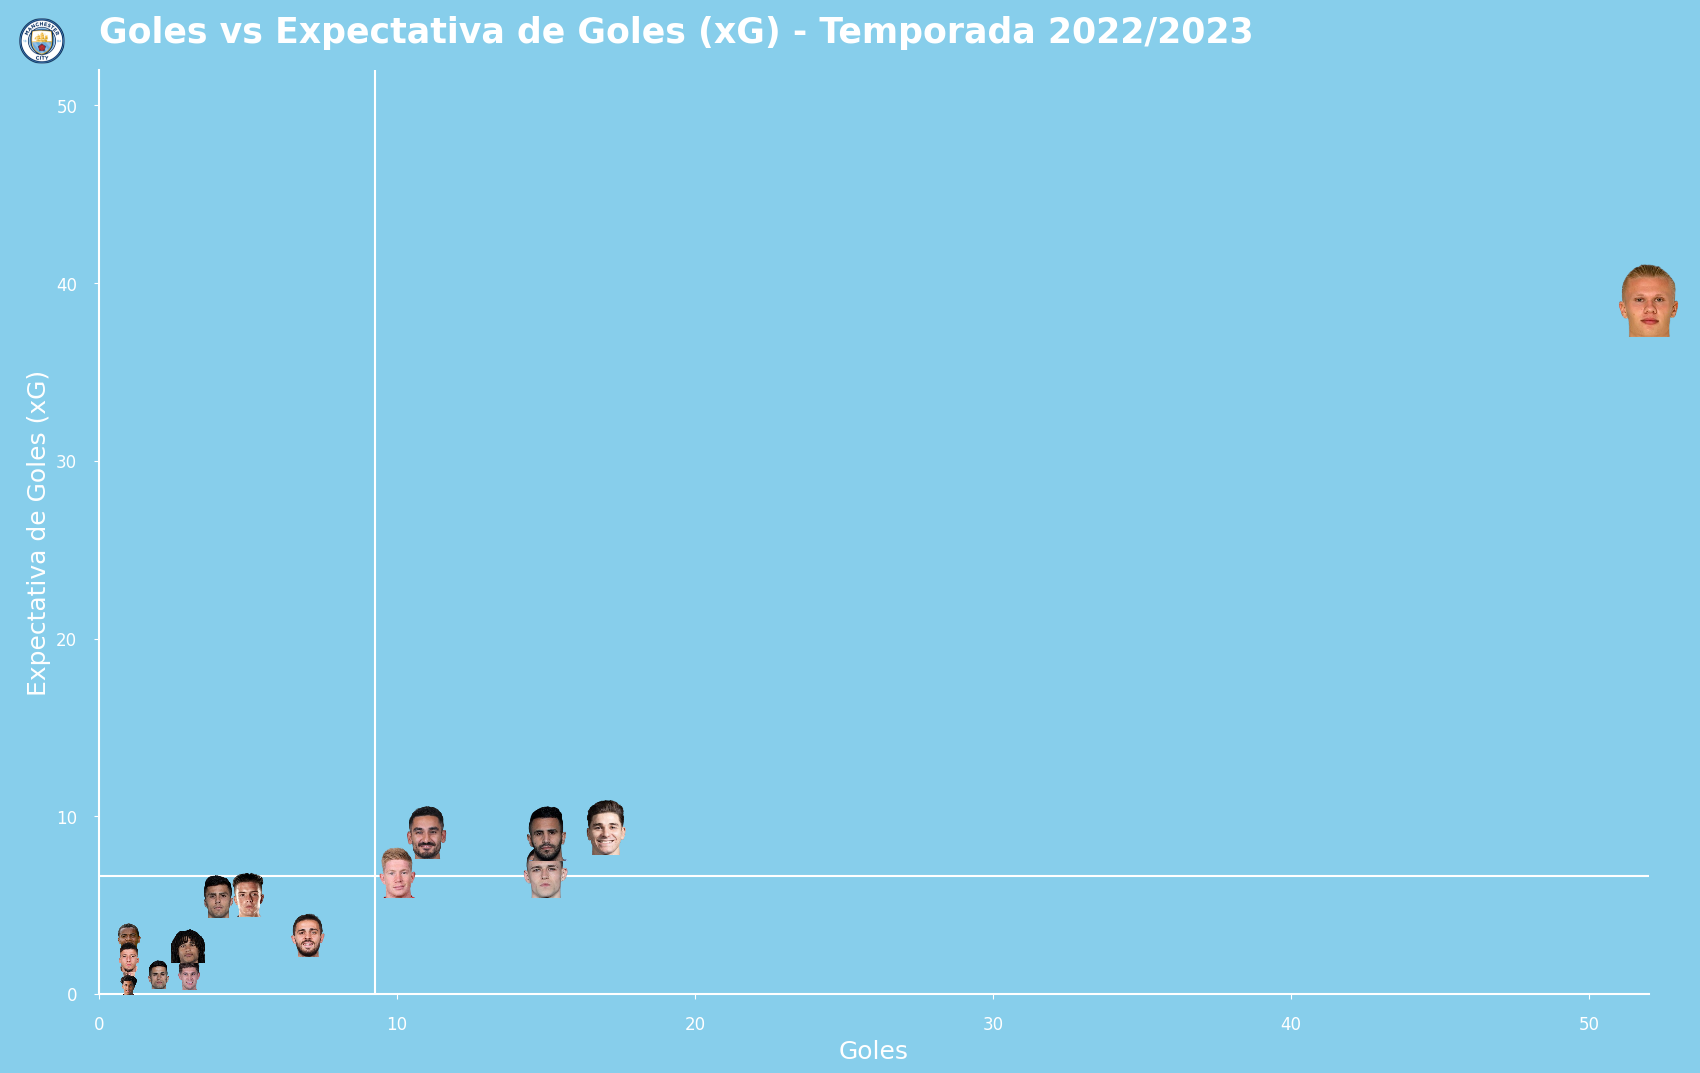

In [21]:
def encontrar_archivo_mas_parecido(jugador, files, threshold=0.6):
    posibles = difflib.get_close_matches(jugador, files, n=1, cutoff=threshold)
    return posibles[0] if posibles else None

# Obtener la lista de archivos en la carpeta 'players'
path = os.getcwd()
files = os.listdir('files')

# Filtrar los jugadores del DataFrame
jugadores_filtrados = df_plot["Jugador"].tolist()
files_filtrados = []

# Recorremos los jugadores y buscamos archivos similares
for jugador in jugadores_filtrados:
    jugador_normalizado = jugador.lower().replace(" ", "_")
    archivo_similar = encontrar_archivo_mas_parecido(jugador_normalizado, files)
    if archivo_similar:
        files_filtrados.append(archivo_similar)

# Ahora que ya tenemos la lista `files_filtrados`, puedes proceder a llamar a la función de ploteo
plot_stats(
    df=df_plot,
    stat_x="Rendimiento_Gls.",
    stat_y="Expectativa_xG",
    title="Temporada 2022/2023",
    xlabel="Goles",
    ylabel="Expectativa de Goles (xG)",
    files_filtrados=files_filtrados  # Lista de rutas de imágenes de jugadores
)

In [22]:
df_plot = df_stats[['Jugador','Rendimiento_Ass','Expectativa_xAG']]
df_plot = df_plot.iloc[:-2]
df_plot = df_plot[(df_plot['Rendimiento_Ass'] != 0) | (df_plot['Expectativa_xAG'] != 0)]
df_plot = df_plot.sort_values(by="Rendimiento_Ass",ascending=False)
df_plot = df_plot[:16]
df_plot = df_plot.sort_values(by="Jugador")
df_plot = df_plot.dropna()

df_plot

,Jugador,Rendimiento_Ass,Expectativa_xAG
6,Bernardo Silva,6.0,4.6
20,Cole Palmer,1.0,0.6
1,Ederson,1.0,0.2
2,Erling Haaland,9.0,6.1
7,Jack Grealish,11.0,10.0
12,John Stones,3.0,2.1
15,João Cancelo,5.0,1.9
14,Julián Álvarez,4.0,2.8
5,Kevin De Bruyne,28.0,17.2
11,Kyle Walker,1.0,0.4


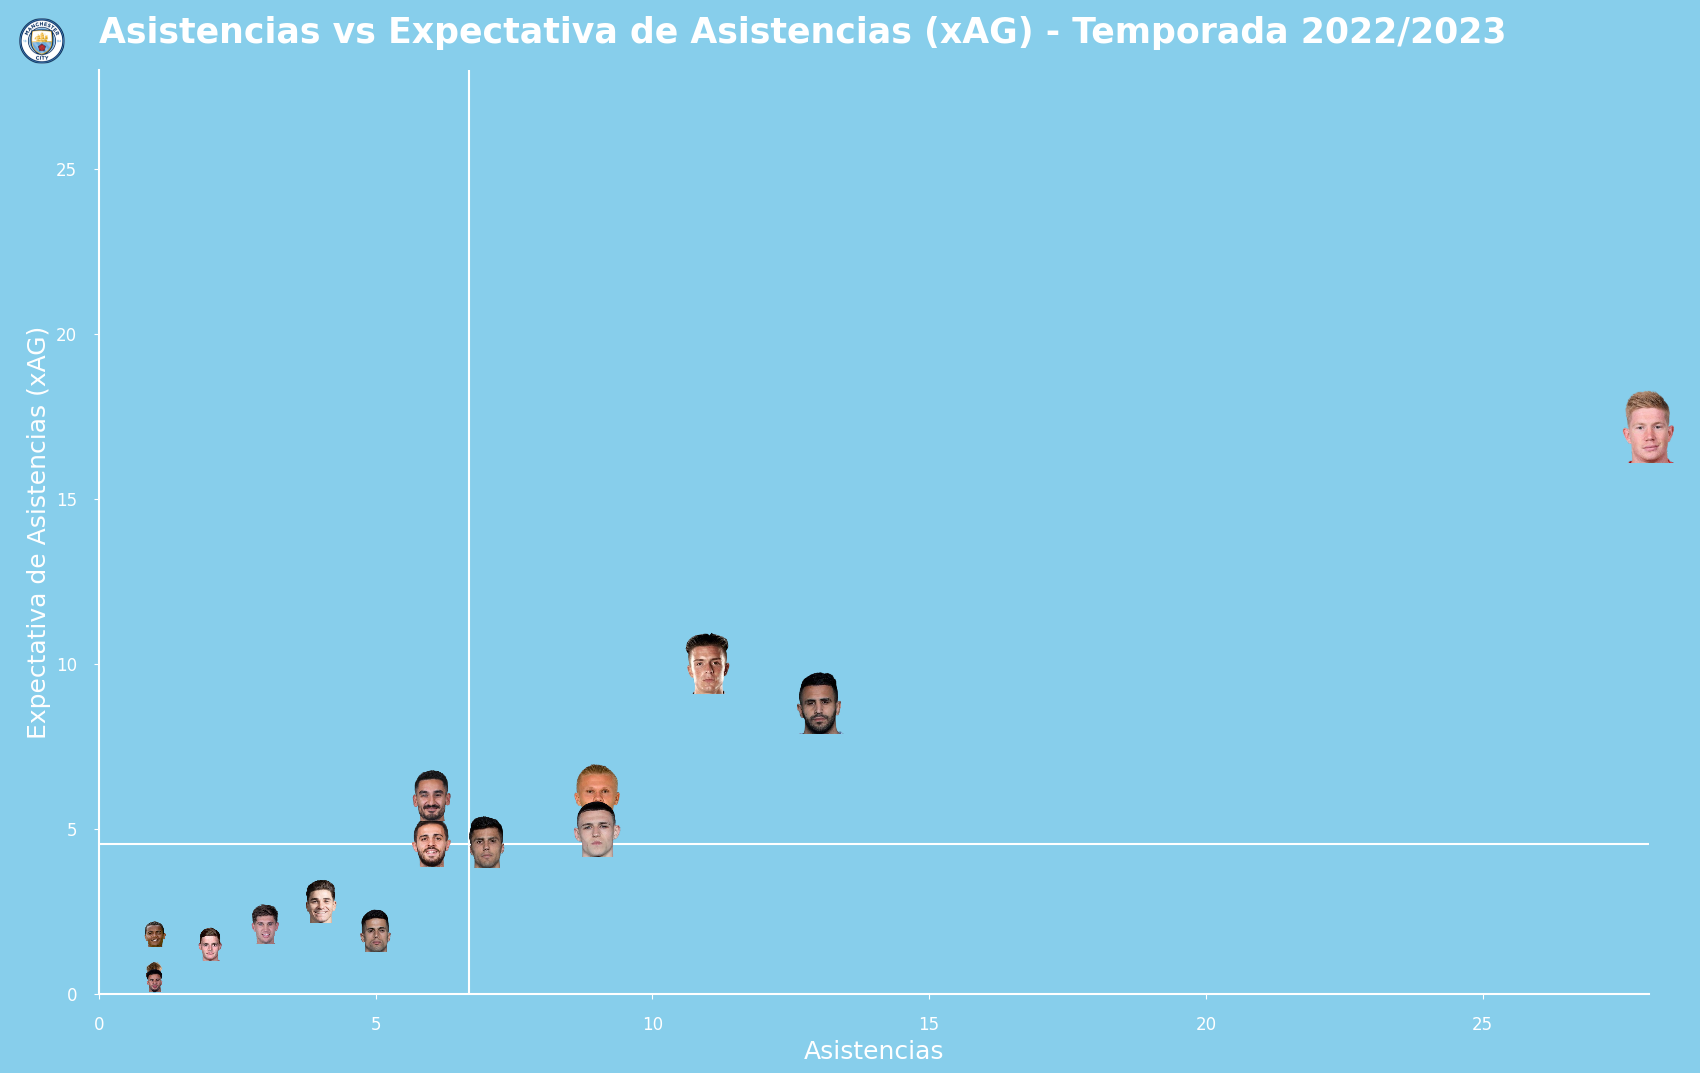

In [23]:
# Filtrar los jugadores del DataFrame
jugadores_filtrados = df_plot["Jugador"].tolist()
files_filtrados = []

# Recorremos los jugadores y buscamos archivos similares
for jugador in jugadores_filtrados:
    jugador_normalizado = jugador.lower().replace(" ", "_")
    archivo_similar = encontrar_archivo_mas_parecido(jugador_normalizado, files)
    if archivo_similar:
        files_filtrados.append(archivo_similar)

plot_stats(
    df=df_plot,
    stat_x="Rendimiento_Ass",
    stat_y="Expectativa_xAG",
    title="Temporada 2022/2023",
    xlabel="Asistencias",
    ylabel="Expectativa de Asistencias (xAG)",
    files_filtrados=files_filtrados  # Lista de rutas de imágenes de jugadores
)


In [67]:
from understatapi import UnderstatClient

with UnderstatClient() as understat:
    player_shot_data = understat.player(player="8260").get_shot_data()
    

In [57]:
df_haaland = pd.DataFrame(player_shot_data)
df_haaland = df_haaland[df_haaland["season"] == "2022"]
df_haaland.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 205 to 327
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               123 non-null    object
 1   minute           123 non-null    object
 2   result           123 non-null    object
 3   X                123 non-null    object
 4   Y                123 non-null    object
 5   xG               123 non-null    object
 6   player           123 non-null    object
 7   h_a              123 non-null    object
 8   player_id        123 non-null    object
 9   situation        123 non-null    object
 10  season           123 non-null    object
 11  shotType         123 non-null    object
 12  match_id         123 non-null    object
 13  h_team           123 non-null    object
 14  a_team           123 non-null    object
 15  h_goals          123 non-null    object
 16  a_goals          123 non-null    object
 17  date             123 non-null    objec

In [58]:
df_haaland['X'] = pd.to_numeric(df_haaland['X']) * 100
df_haaland['Y'] = pd.to_numeric(df_haaland['Y']) * 100
df_haaland['xG'] = pd.to_numeric(df_haaland['xG'])

In [59]:
df_haaland

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
205,479846,20,MissedShots,93.599998,50.299999,0.484085,Erling Haaland,a,8260,OpenPlay,2022,Head,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Phil Foden,Cross
206,479847,35,Goal,88.500000,50.000000,0.761169,Erling Haaland,a,8260,Penalty,2022,LeftFoot,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,None,Standard
207,479854,64,Goal,86.400002,40.500000,0.328053,Erling Haaland,a,8260,OpenPlay,2022,LeftFoot,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Kevin De Bruyne,Throughball
208,479855,69,MissedShots,95.300003,55.200001,0.526608,Erling Haaland,a,8260,OpenPlay,2022,Head,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Jack Grealish,Chipped
209,479856,75,BlockedShot,89.400002,71.000000,0.066443,Erling Haaland,a,8260,OpenPlay,2022,LeftFoot,18211,West Ham,Manchester City,0,2,2022-08-07 15:30:00,Ilkay Gündogan,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,528607,5,MissedShots,96.000000,46.000000,0.539977,Erling Haaland,a,8260,OpenPlay,2022,Head,18515,Brighton,Manchester City,1,1,2023-05-24 19:00:00,Phil Foden,Chipped
324,528612,20,SavedShot,90.099998,53.900002,0.435622,Erling Haaland,a,8260,OpenPlay,2022,LeftFoot,18515,Brighton,Manchester City,1,1,2023-05-24 19:00:00,Phil Foden,Pass
325,528623,47,MissedShots,85.400002,53.200001,0.065928,Erling Haaland,a,8260,OpenPlay,2022,LeftFoot,18515,Brighton,Manchester City,1,1,2023-05-24 19:00:00,Bernardo Silva,Cross
326,528634,65,MissedShots,86.300003,70.300003,0.029277,Erling Haaland,a,8260,OpenPlay,2022,LeftFoot,18515,Brighton,Manchester City,1,1,2023-05-24 19:00:00,Julián Álvarez,Chipped


In [96]:
# Calculate the stats we'll need to display
# 1. Total shots
# 2. Total goals
# 3. Total xG
# 4. xG per shot
# 5. Average distance of shots

total_shots = df_haaland.shape[0]
total_goals = df_haaland[df_haaland['result'] == 'Goal'].shape[0]
total_xG = df_haaland['xG'].sum()
xG_per_shot = total_xG / total_shots
points_average_distance = df_haaland['X'].mean()
actual_average_distance = 110 - (df_haaland['X'] * 1.1).mean()
print(points_average_distance, actual_average_distance)

90.2333329983843 10.74333370177726


In [61]:
# Color -> They went with a black so we'll do the same. Notice how it isn't a pure black but rather a lighter little bit of grey black
background_color='skyblue'

In [66]:
pitch = VerticalPitch(
    pitch_type='opta', 
    half=True, 
    pitch_color=background_color, 
    pad_bottom=.5, 
    line_color='white',
    linewidth=.75,
    axis=True, label=True
)

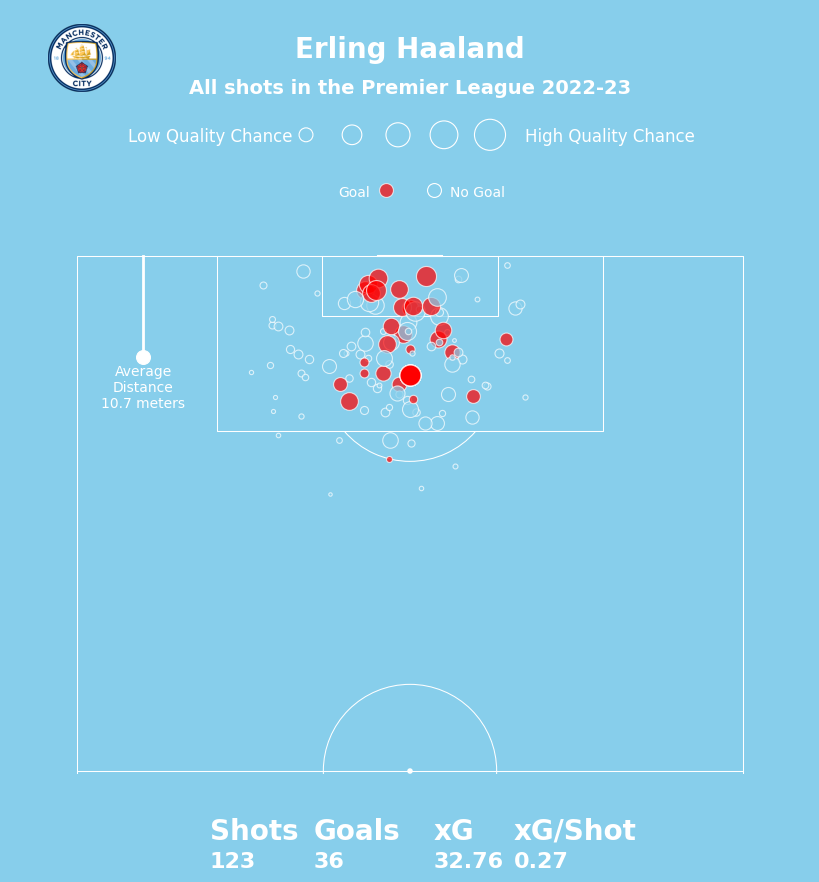

In [121]:
# create a subplot with 2 rows and 1 column
fig = plt.figure(figsize=(8, 12))
fig.patch.set_facecolor(background_color)


# Top row for the team names and score
# [left, bottom, width, height]

ax1 = fig.add_axes([0, 0.7, 1, .2])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)


ax1.text(
    x=0.5, 
    y=.85, 
    s='Erling Haaland', 
    fontsize=20, 
    fontweight='bold', 
    color='white', 
    ha='center'
)
ax1.text(
    x=0.5, 
    y=.7, 
    s=f'All shots in the Premier League 2022-23', 
    fontsize=14,
    fontweight='bold',
    color='white', 
    ha='center'
)
ax1.text(
    x=0.25, 
    y=0.5, 
    s=f'Low Quality Chance', 
    fontsize=12, 
    color='white', 
    ha='center'
)

# add a scatter point between the two texts
x_legend = np.linspace(start=0.37,stop=.6,num=5)
y_legend = np.asarray([.53]*5)
sizes = np.linspace(start=100,stop=500,num=5)

ax1.scatter(x=x_legend,
            y=y_legend,
            s=sizes,
            color=background_color, 
            edgecolor='white', 
            linewidth=.8)

ax1.text(
    x=0.75, 
    y=0.5, 
    s=f'High Quality Chance', 
    fontsize=12, 
    color='white', 
    ha='center'
)

ax1.text(
    x=0.45, 
    y=0.27, 
    s=f'Goal', 
    fontsize=10, 
    color='white', 
    ha='right'
)
ax1.scatter(
    x=0.47, 
    y=0.3, 
    s=100, 
    color='red', 
    edgecolor='white', 
    linewidth=.8,
    alpha=.7
)


ax1.scatter(
    x=0.53, 
    y=0.3, 
    s=100, 
    color=background_color, 
    edgecolor='white', 
    linewidth=.8
)

ax1.text(
    x=0.55, 
    y=0.27, 
    s=f'No Goal', 
    fontsize=10, 
    color='white', 
    ha='left'
)

ax1.set_axis_off()


ax2 = fig.add_axes([.05, 0.25, .9, .5])
ax2.set_facecolor(background_color)

pitch.draw(ax=ax2)


# create a scatter plot at y 100 - average_distance
ax2.scatter(
    x=90, 
    y=points_average_distance, 
    s=100, 
    color='white',  
    linewidth=.8
)
# create a line from the bottom of the pitch to the scatter point
ax2.plot(
    [90, 90], 
    [100, points_average_distance], 
    color='white', 
    linewidth=2
)

# Add a text label for the average distance
ax2.text(
    x=90, 
    y=points_average_distance - 5, 
    s=f'Average\nDistance\n{actual_average_distance:.1f} meters', 
    fontsize=10, 
    color='white', 
    ha='center'
)


for x in df_haaland.to_dict(orient='records'):
    pitch.scatter(
        x['X'], 
        x['Y'], 
        s=300 * x['xG'], 
        color='red' if x['result'] == 'Goal' else background_color, 
        ax=ax2,
        alpha=.7,
        linewidth=.8,
        edgecolor='white'
    )
    
ax2.set_axis_off()

# Configurar el tercer eje para las estadísticas
ax3 = fig.add_axes([0, .2, 1, .05])
ax3.set_facecolor(background_color)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

# Usar un bucle para agregar las estadísticas
stats = [
    {'label': 'Shots', 'value': total_shots, 'x': 0.25},
    {'label': 'Goals', 'value': total_goals, 'x': 0.38},
    {'label': 'xG', 'value': f'{total_xG:.2f}', 'x': 0.53},
    {'label': 'xG/Shot', 'value': f'{xG_per_shot:.2f}', 'x': 0.63}
]

for stat in stats:
    ax3.text(stat["x"], 0.5, s=stat["label"], fontsize=20, fontweight="bold", color = "white", ha = "left", va="center")
    ax3.text(stat["x"], 0, s=stat["value"], fontsize=16, fontweight="bold", color="white", ha="left", va="center")
    
ax3.set_axis_off()

ax_image = add_image(
        Image.open("files\manchestercity.png"), fig, left=0.03, bottom=0.83, height=0.08
        )

plt.show()

In [35]:
df_matches = pagina[6]
df_matches['Fecha'] = pd.to_datetime(df_matches['Fecha'], format='%d-%m-%Y')  # Asegúrate de usar el formato correcto
df_matches["Fecha"].min(), df_matches["Fecha"].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fecha                   61 non-null     object 
 1   Hora                    61 non-null     object 
 2   Comp                    61 non-null     object 
 3   Ronda                   61 non-null     object 
 4   Día                     61 non-null     object 
 5   Sedes                   61 non-null     object 
 6   Resultado               61 non-null     object 
 7   GF                      61 non-null     int64  
 8   GC                      61 non-null     int64  
 9   Adversario              61 non-null     object 
 10  xG                      51 non-null     float64
 11  xGA                     51 non-null     float64
 12  Pos.                    61 non-null     int64  
 13  Asistencia              60 non-null     float64
 14  Capitán                 61 non-null     obje

('2022-07-30', '2023-06-10')

### 1. **Análisis de rendimiento en casa vs fuera**
   - **Descripción**: Compara el rendimiento del Manchester City cuando juega en casa vs cuando juega como visitante. Puedes analizar cómo varían las métricas de goles a favor (GF), goles en contra (GC), y xG dependiendo de la sede.
   - **Columnas relevantes**: `'Sedes'`, `'GF'`, `'GC'`, `'xG'`, `'xGA'`
   - **Visualización sugerida**: Gráficos de barras o gráficos de líneas para mostrar cómo varía el rendimiento en casa y fuera.
   
   **Ejemplo**:
   - ¿El Manchester City marca más goles o tiene un mejor xG en casa que fuera de casa?

In [34]:
partidos_casa = df_matches[df_matches['Sedes'] == 'Local']
partidos_fuera = df_matches[df_matches['Sedes'] == 'Visitante']

In [58]:
# Métricas en casa
promedio_casa_GF = partidos_casa['GF'].mean()
promedio_casa_GC = partidos_casa['GC'].mean()
promedio_casa_xG = partidos_casa['xG'].mean()
promedio_casa_xGA = partidos_casa['xGA'].mean()

# Métricas fuera
promedio_fuera_GF = partidos_fuera['GF'].mean()
promedio_fuera_GC = partidos_fuera['GC'].mean()
promedio_fuera_xG = partidos_fuera['xG'].mean()
promedio_fuera_xGA = partidos_fuera['xGA'].mean()

print(f"Promedio de GF en casa: {promedio_casa_GF}")
print(f"Promedio de GC en casa: {promedio_casa_GC}")
print(f"Promedio de xG en casa: {promedio_casa_xG}")
print(f"Promedio de xGA en casa: {promedio_casa_xGA}")
print()
print(f"Promedio de GF fuera: {promedio_fuera_GF}")
print(f"Promedio de GC fuera: {promedio_fuera_GC}")
print(f"Promedio de xG fuera: {promedio_fuera_xG}")
print(f"Promedio de xGA fuera: {promedio_fuera_xGA}")

Promedio de GF en casa: 3.3333333333333335
Promedio de GC en casa: 0.7
Promedio de xG en casa: 2.3480000000000003
Promedio de xGA en casa: 0.6560000000000001

Promedio de GF fuera: 1.6296296296296295
Promedio de GC fuera: 0.7777777777777778
Promedio de xG fuera: 1.8159999999999998
Promedio de xGA fuera: 0.9920000000000002


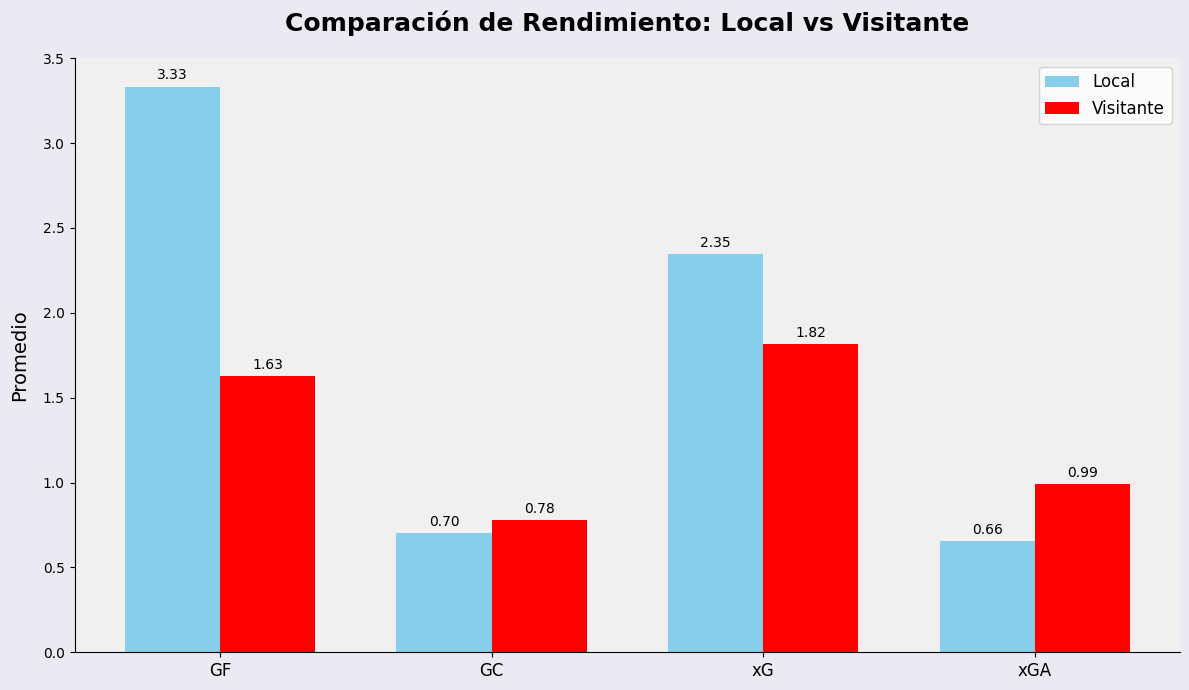

In [60]:
categorias = ['GF', 'GC', 'xG', 'xGA']
valores_casa = [promedio_casa_GF, promedio_casa_GC, promedio_casa_xG, promedio_casa_xGA]  # Ejemplo de valores para partidos en casa
valores_fuera = [promedio_fuera_GF, promedio_fuera_GC, promedio_fuera_xG, promedio_fuera_xGA]  # Ejemplo de valores para partidos fuera

# Configuración del gráfico
x = np.arange(len(categorias))  # etiquetas para las categorías
width = 0.35  # ancho de las barras

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, valores_casa, width, label='Local', color='skyblue')
rects2 = ax.bar(x + width/2, valores_fuera, width, label='Visitante', color='red')

# Añadir etiquetas y título con formato mejorado
ax.set_ylabel('Promedio', fontsize=14, labelpad=10)
ax.set_title('Comparación de Rendimiento: Local vs Visitante', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=12)
ax.legend(fontsize=12)

# Añadir etiquetas encima de las barras
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 puntos de desplazamiento
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Añadir fondo personalizado y estético
ax.set_facecolor('#f0f0f0')
fig.patch.set_facecolor('#eaeaf2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### 2. **Tendencias a lo largo de la temporada**
   - **Descripción**: Analiza las tendencias del rendimiento del equipo a lo largo de la temporada. Puedes observar cómo varían las métricas de goles, xG, y goles en contra conforme avanza la temporada.
   - **Columnas relevantes**: `'Fecha'`, `'GF'`, `'GC'`, `'xG'`, `'xGA'`
   - **Visualización sugerida**: Gráficos de líneas que muestren la evolución de las métricas clave durante la temporada.
   
   **Ejemplo**:
   - ¿Hubo algún periodo durante la temporada donde el rendimiento del equipo cayó o mejoró notablemente?

In [70]:
# Convertir la columna 'Fecha' al tipo datetime si no lo está
df_matches['Fecha'] = pd.to_datetime(df_matches['Fecha'], format='%Y-%m-%d')  # Asegúrate de usar el formato correcto

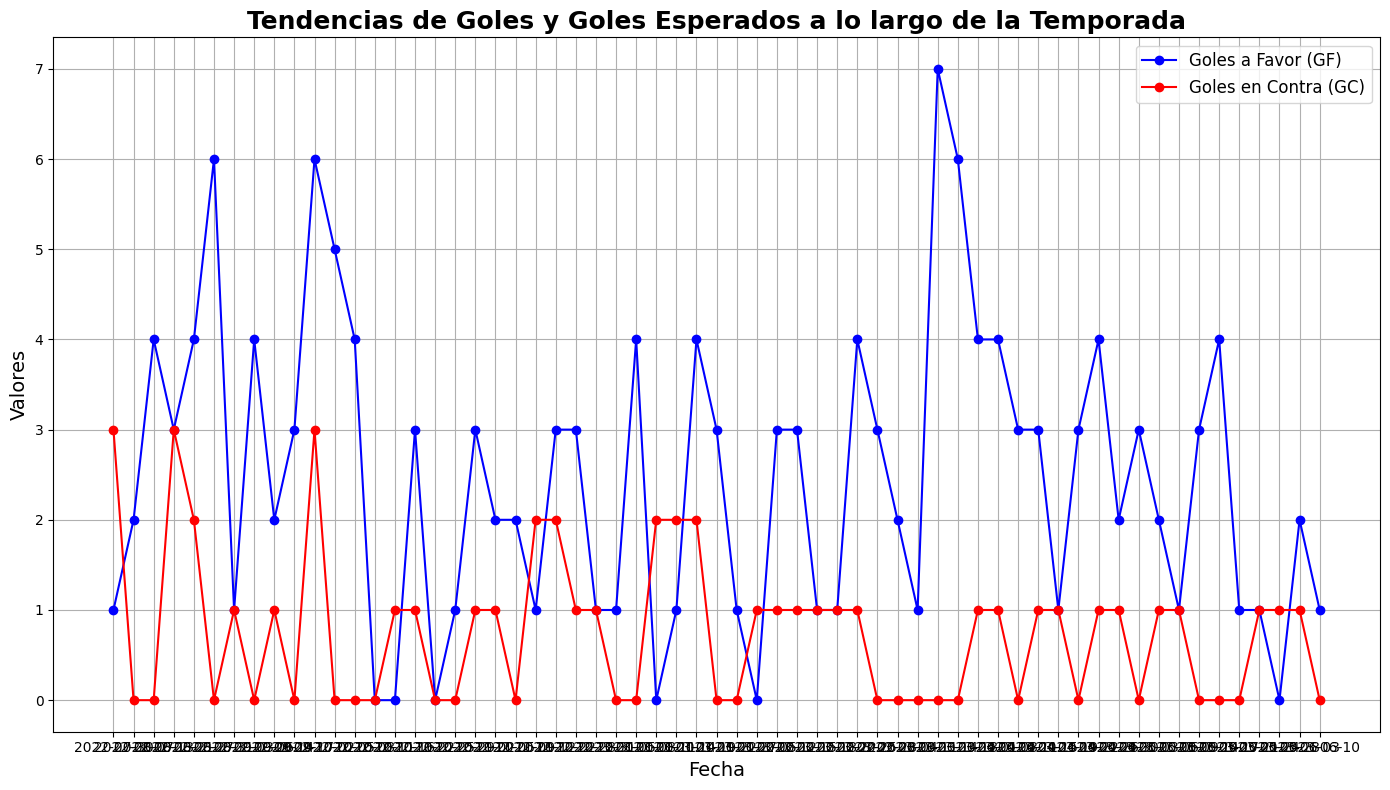

In [75]:
# Definir las métricas clave para observar las tendencias
fechas = df_matches['Fecha']
goles_favor = df_matches['GF']
goles_contra = df_matches['GC']

# Crear el gráfico combinado
plt.figure(figsize=(14, 8))

# Goles a Favor (GF)
plt.plot(fechas, goles_favor, color='blue', marker='o', linestyle='-', label='Goles a Favor (GF)')

# Goles en Contra (GC)
plt.plot(fechas, goles_contra, color='red', marker='o', linestyle='-', label='Goles en Contra (GC)')

# Título y etiquetas de los ejes
plt.title('Tendencias de Goles y Goles Esperados a lo largo de la Temporada', fontsize=18, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Valores', fontsize=14)

# Añadir la leyenda
plt.legend(fontsize=12)

# Añadir cuadrícula
plt.grid(True)

# Ajustar el layout
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [63]:
# Ordenar el DataFrame por la columna 'Fecha'
df = df.sort_values(by='Fecha')

KeyError: 'Fecha'



### 3. **Análisis de los rivales más complicados**
   - **Descripción**: Examina cuáles han sido los rivales más difíciles para el Manchester City, en términos de goles en contra, xGA, y resultados obtenidos. Puedes identificar los equipos contra los que más se ha complicado el City durante la temporada.
   - **Columnas relevantes**: `'Adversario'`, `'GF'`, `'GC'`, `'xG'`, `'xGA'`
   - **Visualización sugerida**: Gráfico de barras o heatmaps para comparar los resultados contra diferentes adversarios.

   **Ejemplo**:
   - ¿Cuáles han sido los equipos más complicados para el Manchester City en términos defensivos y ofensivos?

In [10]:
pagina[5].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Total                                    ...  \
                90 s   Cmp  Int. % Cmp Dist. tot. Dist. prg.  ...   
0               35.0  1079  1257  85.8      26248      17275  ...   
1               32.3  2723  2987  91.2      49949      11936  ...   
2               30.8   360   500  72.0       4403        947  ...   
3               26.9  1192  1626  73.3      22165       6516  ...   
4               26.1  1374  1578  87.1      21396       4941  ...   

  Unnamed: 19_level_0 Unnamed: 20_level_0 Expectativa        \
                  Ass                 xAG          xA A-xAG   
0                   1                 0.2         0.2   0.8   
1                   6                 4.1         3.5   1.9   
2                   8                 5.3         3.1   2.7   
3                  16                13.7        14.1   2.3   
4                   4                 3.3         4.4   0.7   

  Unnamed: 23_level_0 Unnamed: 24_level_0 Unnamed: 25_level_0  \
                   PC                 1/3                 PPA   
0                   1                  13                   0   
1                  32                 265                  33   
2                  29                  14                  23   
3                  96                 124                  96   
4                  37                 143                  35   

  Unnamed: 26_level_0 Unnamed: 27_level_0 Unnamed: 28_level_0  
                 CrAP                PrgP            Partidos  
0                   0                   0            Partidos  
1                   3                 260            Partidos  
2                   0                  58            Partidos  
3                  21                 246            Partidos  
4                   1                 170            Partidos  

[5 rows x 29 columns]

In [11]:
pagina[6].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Unnamed: 5_level_0 Tipos de pases                       \
                90 s               Int.     Balón vivo Balón muerto  FK  PL   
0               35.0               1257           1049          207  55   1   
1               32.3               2987           2943           43  37   2   
2               30.8                500            449           45   0   4   
3               26.9               1626           1454          160  53  28   
4               26.1               1578           1519           56  24  18   

   ...                Saques de esquina             Resultados               \
   ...  Pcz Lanz.  SE            Dentro Fuera Rect.        Cmp  PA Bloqueos   
0  ...    0     0   0                 0     0     0       1079   1        1   
1  ...    6     3   0                 0     0     0       2723   1       21   
2  ...   12     2   1                 0     0     0        360   6       21   
3  ...  226    31  72                20    32     6       1192  12       41   
4  ...   30     5  21                 7     4     1       1374   3       27   

  Unnamed: 20_level_0  
             Partidos  
0            Partidos  
1            Partidos  
2            Partidos  
3            Partidos  
4            Partidos  

[5 rows x 21 columns]

In [12]:
pagina[7].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0  ACT       Tipos de SCA                 ...     ACG  \
                90 s  ACT SCA90     PassLive PassDead HASTA  ... Def ACG   
0               35.0    2  0.06            2        0     0  ...   0   1   
1               32.3   92  2.84           80        0     4  ...   1  10   
2               30.8   72  2.34           48        0     5  ...   1  17   
3               26.9  176  6.55          120       33     8  ...   3  31   
4               26.1   90  3.44           71        7     2  ...   2  17   

        Tipos de GCA                           Unnamed: 21_level_0  
  GCA90     PassLive PassDead HASTA Dis FR Def            Partidos  
0  0.03            1        0     0   0  0   0            Partidos  
1  0.31           10        0     0   0  0   0            Partidos  
2  0.55           14        0     0   1  2   0            Partidos  
3  1.15           24        3     1   1  2   0            Partidos  
4  0.65           13        1     0   1  2   0            Partidos  

[5 rows x 22 columns]

In [13]:
pagina[8].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Derribos                                    ... Desafíos  \
                90 s      Tkl TklG 3.º def. 3.º cent. 3.º ataq.  ...     Tkl%   
0               35.0        3    1        3         0         0  ...     50.0   
1               32.3       67   41       28        28        11  ...     49.1   
2               30.8        3    2        0         2         1  ...     20.0   
3               26.9       28   12        3        12        13  ...     35.9   
4               26.1       30   18        7        13        10  ...     35.3   

          Bloqueos           Unnamed: 17_level_0 Unnamed: 18_level_0  \
  Pérdida Bloqueos Dis Pases                 Int             Tkl+Int   
0       1        0   0     0                   1                   4   
1      27       40  14    26                  33                 100   
2       4       12   4     8                   3                   6   
3      25       27   2    25                   9                  37   
4      22       18   3    15                  20                  50   

  Unnamed: 19_level_0 Unnamed: 20_level_0 Unnamed: 21_level_0  
                Desp.                 Err            Partidos  
0                  10                   2            Partidos  
1                  43                   1            Partidos  
2                  14                   0            Partidos  
3                  10                   0            Partidos  
4                  13                   0            Partidos  

[5 rows x 22 columns]

In [14]:
pagina[9].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Toques                                         ...  \
                90 s Toques Def. pen. 3.º def. 3.º cent. 3.º ataq.  ...   
0               35.0   1302      1049     1295         9         0  ...   
1               32.3   3272       119      706      1993       592  ...   
2               30.8    763        18       39       290       435  ...   
3               26.9   1860        13      100       743      1041  ...   
4               26.1   1806        31      243       975       596  ...   

  Transportes                                                Recepción       \
   Dist. tot. Dist. prg. PrgC 1/3 TAP Errores de control Des       Rec PrgR   
0        4059       2429    0   0   0                  0   0       833    0   
1       10293       5622   76  72   3                 21  19      2511   37   
2        2020        761   35  10  25                 51  26       583  151   
3        5721       3415  100  81  16                 42  29      1445  245   
4        5457       2628   53  44   7                 28  27      1425  124   

  Unnamed: 27_level_0  
             Partidos  
0            Partidos  
1            Partidos  
2            Partidos  
3            Partidos  
4            Partidos  

[5 rows x 28 columns]

In [15]:
pagina[9].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Toques                                         ...  \
                90 s Toques Def. pen. 3.º def. 3.º cent. 3.º ataq.  ...   
0               35.0   1302      1049     1295         9         0  ...   
1               32.3   3272       119      706      1993       592  ...   
2               30.8    763        18       39       290       435  ...   
3               26.9   1860        13      100       743      1041  ...   
4               26.1   1806        31      243       975       596  ...   

  Transportes                                                Recepción       \
   Dist. tot. Dist. prg. PrgC 1/3 TAP Errores de control Des       Rec PrgR   
0        4059       2429    0   0   0                  0   0       833    0   
1       10293       5622   76  72   3                 21  19      2511   37   
2        2020        761   35  10  25                 51  26       583  151   
3        5721       3415  100  81  16                 42  29      1445  245   
4        5457       2628   53  44   7                 28  27      1425  124   

  Unnamed: 27_level_0  
             Partidos  
0            Partidos  
1            Partidos  
2            Partidos  
3            Partidos  
4            Partidos  

[5 rows x 28 columns]

In [16]:
pagina[10].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Tiempo Jugado                   Titular  ...  \
                  PJ           Mín Mn/PJ % min  90 s Titular  ...   
0                 35        3150.0  90.0  92.1  35.0      35  ...   
1                 36        2911.0  81.0  85.1  32.3      34  ...   
2                 35        2769.0  79.0  81.0  30.8      33  ...   
3                 32        2417.0  76.0  70.7  26.9      28  ...   
4                 31        2353.0  76.0  68.8  26.1      27  ...   

  Logros del equipo                          Logros del equipo (xG)        \
               onGA   +/- +/-90 Dentro-Fuera                   onxG onxGA   
0              32.0  57.0  1.63         0.30                   73.3  28.3   
1              26.0  57.0  1.76         1.06                   67.4  24.4   
2              26.0  58.0  1.89         1.47                   66.9  24.3   
3              23.0  46.0  1.71         0.37                   58.7  19.4   
4              20.0  51.0  1.95         1.11                   61.3  19.4   

                             Unnamed: 26_level_0  
  xG+/- xG+/-90 Dentro-Fuera            Partidos  
0  45.1    1.29         0.81            Partidos  
1  43.0    1.33         0.71            Partidos  
2  42.6    1.38         0.84            Partidos  
3  39.2    1.46         0.81            Partidos  
4  41.9    1.60         1.21            Partidos  

[5 rows x 27 columns]

In [17]:
pagina[11].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
             Jugador               País               Posc               Edad   
0            Ederson             br BRA                 PO               28.0   
1              Rodri             es ESP                 CC               26.0   
2     Erling Haaland             no NOR                 DL               22.0   
3    Kevin De Bruyne             be BEL                 CC               31.0   
4     İlkay Gündoğan             de GER                 CC               31.0   

  Unnamed: 4_level_0 Rendimiento                         ...           \
                90 s          TA TR 2a amarilla Fls  FR  ... Int TklG   
0               35.0           3  0           0   1   4  ...   1    1   
1               32.3           5  0           0  47  20  ...  33   41   
2               30.8           5  0           0  31  24  ...   3    2   
3               26.9           1  0           0  20  29  ...   9   12   
4               26.1           0  0           0  23  25  ...  20   18   

                                            Duelos aéreos           \
  Penal ejecutado Penal concedido GC Recup.       Ganados Perdidos   
0               0               1  0     35             8        1   
1               0               0  0    301            72       32   
2               1               0  0     37            50       50   
3               2               0  0     97            13       13   
4               2               0  0    155            19       12   

               Unnamed: 21_level_0  
  % de ganados            Partidos  
0         88.9            Partidos  
1         69.2            Partidos  
2         50.0            Partidos  
3         50.0            Partidos  
4         61.3            Partidos  

[5 rows x 22 columns]

In [18]:
pagina[12].head()

,RL,Equipo,PJ,PG,PE,PP,GF,GC,DG,Pts,Pts/PJ,xG,xGA,xGD,xGD/90,Asistencia,Máximo Goleador del Equipo,Portero,Notas
0,1,Manchester City,38,28,5,5,94,33,61,89,2.34,78.6,32.1,46.5,1.22,53249,Erling Haaland - 36,Ederson,→ Champions League Por el final de liga
1,2,Arsenal,38,26,6,6,88,43,45,84,2.21,71.6,42.0,29.6,0.78,60191,"Martin Ødegaard, Gabriel Martinelli - 15",Aaron Ramsdale,→ Champions League Por el final de liga
2,3,Manchester Utd,38,23,6,9,58,43,15,75,1.97,67.7,50.4,17.3,0.45,73671,Marcus Rashford - 17,David de Gea,→ Champions League Por el final de liga


In [19]:
pagina[13].head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Local                            ...  \
                  RL             Equipo    PJ  PG PE PP  GF  GC  DG Pts  ...   
0                  1    Manchester City    19  17  1  1  60  17  43  52  ...   
1                  2            Arsenal    19  14  3  2  53  25  28  45  ...   
2                  3     Manchester Utd    19  15  3  1  36  10  26  48  ...   

  Visitante                                                  
         PP  GF  GC  DG Pts Pts/PJ    xG   xGA   xGD xGD/90  
0         4  34  16  18  37   1.95  35.9  19.3  16.6   0.87  
1         4  35  18  17  39   2.05  29.1  22.7   6.4   0.34  
2         8  22  33 -11  27   1.42  26.7  31.0  -4.3  -0.22  

[3 rows x 28 columns]